In [1]:
from google.colab import files

uploaded = files.upload()   # Choose your ZIP file here


Saving archive (20).zip to archive (20).zip


In [2]:
zip_name = list(uploaded.keys())[0]
print("Uploaded file:", zip_name)


Uploaded file: archive (20).zip


In [3]:
import zipfile
import os

extract_path = "/content/dataset"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction done")


Extraction done


In [4]:
# Flatten directory if Images/Masks are inside another folder
for root, dirs, files in os.walk(extract_path):
    if "Images" in dirs and "Masks" in dirs:
        base = root
        if base != extract_path:
            os.system(f"mv {base}/* {extract_path}/")
        break

print("Final dataset folders:", os.listdir(extract_path))


Final dataset folders: ['Water Bodies Dataset']


In [5]:
import os

base_path = "/content/dataset/Water Bodies Dataset"
target_path = "/content/dataset"

# Move Images and Masks up one level
os.system(f'mv "{base_path}/Images" "{target_path}/"')
os.system(f'mv "{base_path}/Masks" "{target_path}/"')

# (Optional) remove empty folder
os.system(f'rm -r "{base_path}"')

print("Final dataset folders:", os.listdir(target_path))


Final dataset folders: ['Images', 'Masks']


In [6]:
!pip install tensorflow opencv-python


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam


In [9]:
IMG_SIZE = 128

def load_data(image_dir, mask_dir):
    images, masks = [], []
    file_names = sorted(os.listdir(image_dir))

    for f in file_names:
        img = cv2.imread(os.path.join(image_dir, f))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        mask = cv2.imread(os.path.join(mask_dir, f), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

IMAGE_DIR = "/content/dataset/Images"
MASK_DIR = "/content/dataset/Masks"

X, y = load_data(IMAGE_DIR, MASK_DIR)

print("Images shape:", X.shape)
print("Masks shape:", y.shape)


Images shape: (2841, 128, 128, 3)
Masks shape: (2841, 128, 128, 1)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])


Training samples: 2272
Validation samples: 569


In [12]:
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

model = unet_model()

model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8,      │          0 │ conv2d_9[0][0]  

 Total params: 31,032,837 (118.38 MB)

 Trainable params: 31,032,837 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,      # use 10 if GPU time is limited
    batch_size=8
)


Epoch 1/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 103s 218ms/step - accuracy: 0.6039 - loss: 0.5498 - val_accuracy: 0.7076 - val_loss: 0.4028
Epoch 2/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 49s 173ms/step - accuracy: 0.6968 - loss: 0.4141 - val_accuracy: 0.6948 - val_loss: 0.4169
Epoch 3/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 49s 171ms/step - accuracy: 0.7107 - loss: 0.3885 - val_accuracy: 0.7212 - val_loss: 0.3590
Epoch 4/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 49s 173ms/step - accuracy: 0.7212 - loss: 0.3634 - val_accuracy: 0.7324 - val_loss: 0.3350
Epoch 5/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 49s 172ms/step - accuracy: 0.7297 - loss: 0.3415 - val_accuracy: 0.7379 - val_loss: 0.3135
Epoch 6/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 49s 173ms/step - accuracy: 0.7410 - loss: 0.3117 - val_accuracy: 0.7464 - val_loss: 0.2952
Epoch 7/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 49s 173ms/step - accuracy: 0.7431 - loss: 0.3001 - val_accuracy: 0.7499 - val_loss: 0.2776
Epoch 8/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 49s 173ms/step - accuracy: 0.7497 - loss: 

In [14]:
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(len(X_val))

prediction = model.predict(np.expand_dims(X_val[idx], axis=0))[0]
pred_mask = (prediction > 0.5).astype(np.uint8)

water_pixels = np.sum(pred_mask)
total_pixels = pred_mask.shape[0] * pred_mask.shape[1]

water_percentage = (water_pixels / total_pixels) * 100
print(f"💧 Water Present: {water_percentage:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
💧 Water Present: 100.00%


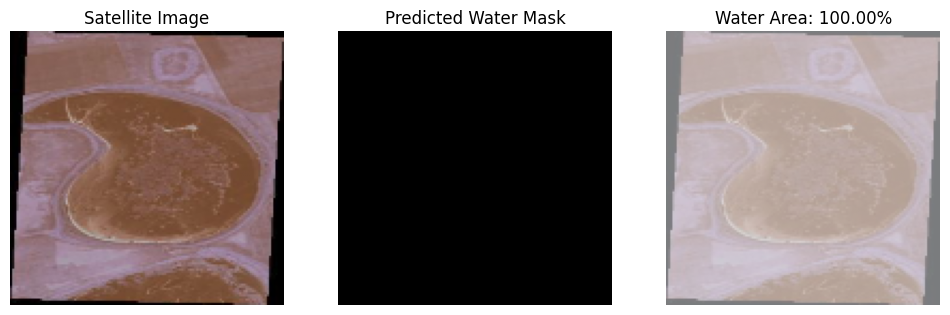

In [29]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Satellite Image")
plt.imshow(X_val[idx])
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Predicted Water Mask")
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.title(f"Water Area: {water_percentage:.2f}%")
plt.imshow(X_val[idx])
plt.imshow(pred_mask.squeeze(), cmap='Blues', alpha=0.5)
plt.axis("off")

plt.show()


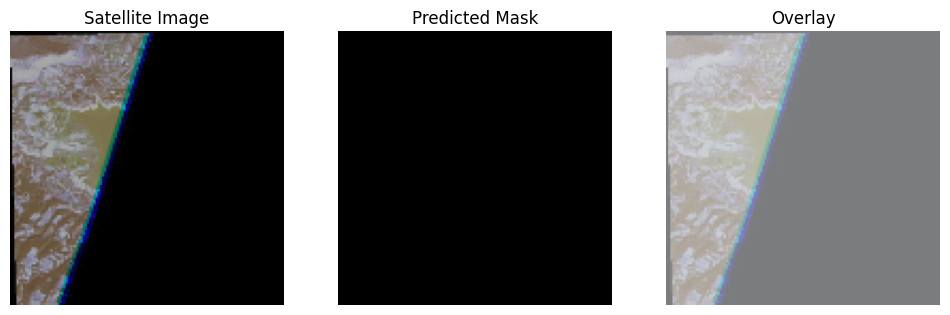

In [16]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Satellite Image")
plt.imshow(X_val[idx])
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Predicted Mask")
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(X_val[idx])
plt.imshow(pred_mask.squeeze(), cmap='Blues', alpha=0.5)
plt.axis("off")

plt.show()


In [20]:
percentages = []

for i in range(10):
    idx = np.random.randint(len(X_val))
    pred = model.predict(np.expand_dims(X_val[idx], axis=0))[0]
    mask = (pred > 0.5).astype(np.uint8)

    water_pixels = np.sum(mask)
    total_pixels = mask.shape[0] * mask.shape[1]
    percentages.append((water_pixels / total_pixels) * 100)

print("Water percentages:", percentages)
print(f"Average water percentage: {np.mean(percentages):.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Water percentages: [np.float64(51.971435546875), np.float64(20.05615234375), np.float64(29.33349609375), np.float64(36.53564453125), np.float64(41.131591796875), np.float64(23.9013671875), np.float64(16.80908203125), np.float64(22.03369140625), np.float64(14.080810546875), np.float64(27.1240234375)]
Average water percentage: 28.30%


In [18]:
model.save("/content/water_body_segmentation_unet.h5")
print("💾 Model saved successfully")


💾 Model saved successfully


In [21]:
np.random.seed(42)


In [22]:
indices = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450]

percentages = []

for idx in indices:
    pred = model.predict(np.expand_dims(X_val[idx], axis=0))[0]
    mask = (pred > 0.5).astype(np.uint8)

    water_pixels = np.sum(mask)
    total_pixels = mask.shape[0] * mask.shape[1]
    percentages.append((water_pixels / total_pixels) * 100)

print("Water percentages:", percentages)
print(f"Final Average Water Percentage: {np.mean(percentages):.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Water percentages: [np.float64(39.892578125), np.float64(16.461181640625), np.float64(18.27392578125), np.float64(23.077392578125), np.float64(30.40771484375), np.float64(45.953369140625), np.float64(46.8017578125), np.float64(17.205810546875), np.float64(13.57421875), np.float64(34.814453125)]
Final Average Water Percentage: 28.65%


In [23]:
percentages = []

for i in range(len(X_val)):
    pred = model.predict(np.expand_dims(X_val[i], axis=0))[0]
    mask = (pred > 0.5).astype(np.uint8)

    water_pixels = np.sum(mask)
    total_pixels = mask.shape[0] * mask.shape[1]
    percentages.append((water_pixels / total_pixels) * 100)

print(f"Dataset Average Water Percentage: {np.mean(percentages):.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━